In [1]:
pip install albumentations==0.4.6

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 117 kB 4.7 MB/s 
     |████████████████████████████████| 948 kB 33.2 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65174 sha256=39d21cef4d8ef7a0e638fd6093fe10ebccee1a7ba46411cc0d7b5fc22b7e929c
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [29]:
import sys
sys.path.insert(0,'/content/drive/MyDrive/Colab Notebooks')

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import cv2
from torchvision import datasets,transforms
from glob import glob
import os
from PIL import Image
import sklearns as sk
from matplotlib import patches
from torch.utils.data import Dataset
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torch.utils.data import DataLoader
#Albumentation
import albumentations as al
from albumentations.pytorch.transforms import ToTensorV2

In [4]:
train_dir ='/content/drive/MyDrive/global_wheat/train/'
test_dir = '/content/drive/MyDrive/global_wheat/test/'
train = pd.read_csv( '/content/drive/MyDrive/global_wheat/train.csv' )

weights = '/content/drive/MyDrive/global_wheat/fasterrcnn.pth'

sample = pd.read_csv('/content/drive/MyDrive/global_wheat/sample_submission.csv')
sample.shape

(10, 2)

In [5]:
sample

,image_id,PredictionString
0,aac893a91,1.0 0 0 50 50
1,51f1be19e,1.0 0 0 50 50
2,f5a1f0358,1.0 0 0 50 50
3,796707dd7,1.0 0 0 50 50
4,51b3e36ab,1.0 0 0 50 50
5,348a992bb,1.0 0 0 50 50
6,cc3532ff6,1.0 0 0 50 50
7,2fd875eaa,1.0 0 0 50 50
8,cb8d261a3,1.0 0 0 50 50
9,53f253011,1.0 0 0 50 50


In [36]:
class Wheatdatasets(Dataset):
    
    def __init__(self,dataframe,image_dir,transforms = None):
        
        super().__init__()
    
        self.image_id = dataframe['image_id'].unique()
        self.df = dataframe
        self.img_dir = image_dir
        self.transforms = transforms
        
    def __getitem__(self,index:int):
        
        image_id = self.image_id[index]
        record = self.df[self.df['image_id']==image_id]
        
        image = cv2.imread(self.img_dir+image_id+'.jpg',cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB).astype(np.float32)
        image = image/255.0

        if self.transforms:
            sample ={
                'image':image
            }
            sample =self.transforms(**sample)
            image = sample['image']
            
            return image,image_id
        
    def __len__(self) -> int:
        return self.image_id.shape[0]
performance_faster_rcnn = sk.performance()

In [7]:
def get_transform():
    return al.Compose([
        ToTensorV2(p=1.0)
    ])

In [8]:
#Create the Model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained = False,pretrained_backbone=False)

In [10]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cpu


In [11]:

num_class = 2 #wheats and background

in_feature = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(in_feature,num_class) #changin the pretrained head with a new one

model.load_state_dict(torch.load(weights, map_location=torch.device('cpu')))
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [12]:
x = model.to(device)

In [13]:
def collate_fn(batch):
    return tuple(zip(*batch))


test_dataset = Wheatdatasets(sample,test_dir,get_transform())



test_dataloader = DataLoader(
test_dataset,
batch_size=4,
shuffle =False,
num_workers =2,drop_last = False,
collate_fn = collate_fn)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [14]:
def format_string(boxes,score):
    pred_strings = []
    for j in zip(score,boxes):
        
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))
        
    return " ".join(pred_strings)

In [16]:
detection_threshold = 0.5
results = []

for images, image_ids in test_dataloader:

    images = list(image.to(device) for image in images)
    outputs = model(images)

    for i, image in enumerate(images):

        boxes = outputs[i]['boxes'].data.cpu().numpy()
        scores = outputs[i]['scores'].data.cpu().numpy()
        
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        scores = scores[scores >= detection_threshold]
        image_id = image_ids[i]
        
        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
        
        result = {
            'image_id': image_id,
            'PredictionString': format_string(boxes, scores)
        }


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [17]:
results[:10]

[]

In [18]:

test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
test_df.head()

,image_id,PredictionString


In [19]:
outputs[:4]

[{'boxes': tensor([[2.5552e+01, 5.6242e+02, 2.0495e+02, 6.6758e+02],
          [2.1015e+01, 8.6778e+02, 1.0397e+02, 1.0128e+03],
          [3.0662e+02, 1.6301e+02, 4.1974e+02, 3.7070e+02],
          [9.0241e+02, 1.7675e+02, 1.0023e+03, 2.9472e+02],
          [7.5341e+02, 7.1566e+02, 8.3800e+02, 7.9974e+02],
          [4.6839e+02, 9.2128e+02, 6.6651e+02, 1.0196e+03],
          [4.3371e+02, 4.6395e+02, 5.5643e+02, 5.6966e+02],
          [5.1484e+02, 2.7101e+02, 6.0596e+02, 4.0341e+02],
          [5.8913e+02, 4.1458e+01, 6.6948e+02, 1.2864e+02],
          [4.3758e+02, 1.1908e+02, 5.4265e+02, 1.9553e+02],
          [2.6443e+02, 7.7729e+02, 3.8310e+02, 8.4798e+02],
          [8.4026e+02, 1.5547e+02, 9.1275e+02, 2.7855e+02],
          [5.9750e+02, 2.4971e+02, 6.7916e+02, 3.7457e+02],
          [1.6919e+02, 9.0866e+02, 2.5833e+02, 9.8475e+02],
          [4.5849e+02, 8.1800e+02, 5.3744e+02, 8.9376e+02],
          [6.8758e+02, 1.2113e+02, 7.7240e+02, 2.8217e+02],
          [7.5810e+02, 4.9290e+

In [23]:
sample = images[0].permute(1,2,0).cpu().numpy()
boxes = outputs[0]['boxes'].data.cpu().numpy()
score = outputs[0]['scores'].data.cpu().numpy()

boxes = boxes[score >= detection_threshold].astype(np.int32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


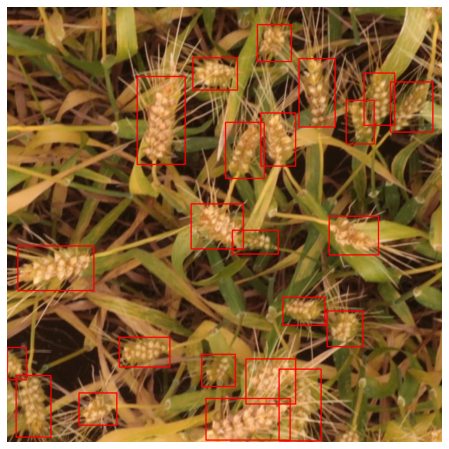

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 2)
    
ax.set_axis_off()
ax.imshow(sample)

In [25]:
sample = images[1].permute(1,2,0).cpu().numpy()
boxes = outputs[1]['boxes'].data.cpu().numpy()
score = outputs[1]['scores'].data.cpu().numpy()

boxes = boxes[score >= detection_threshold].astype(np.int32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


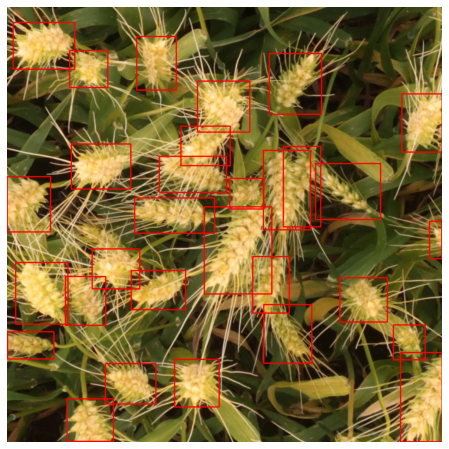

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 2)
    
ax.set_axis_off()
ax.imshow(sample)

In [38]:

performance_faster_rcnn.accuracy()

71.67982708706688